In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

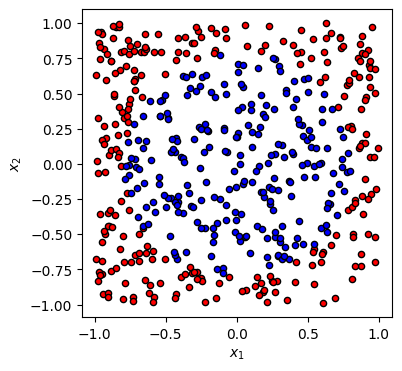

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Simple classifier with data reloading and fidelity loss
=======================================================


In [3]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params: # Iterate num_layer times
        # Basic Encoding
        # p = p[0]
        # qml.Rot(*x, wires=0)
        # qml.Rot(*p, wires=0)
        
        # # # Better Encoding
        # w = p[0]
        # b = p[1]
        # encoding = w * x + b
        # # for rots in encoding:
        # assert len(encoding)==3, "encoding not of length 3. Encoding: " + str(encoding)
        # qml.Rot(*encoding, wires=0)
        
        # Compact Encoding
        w = p[0]
        b = p[1]
        # print('w: ', w)
        # print('b: ', b)
        encoding = np.dot(w, x) + b[0]
        # print('encoding', encoding)
        # encoding = [encoding]*3
        # for rots in encoding:
        # assert len(encoding)==3, "encoding not of length 3. Encoding: " + str(encoding)
        qml.Rot(encoding, encoding, encoding, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss += (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
==================================================


In [4]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Train a quantum classifier on the circle dataset
================================================


In [5]:
# Generate training and test data
num_training = 500
num_test = 200

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))



In [6]:
%%time
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.6
epochs = 5
batch_size = 32
n_features = 3
opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)


# initialize random weights
params = np.random.uniform(size=(num_layers, 2, n_features), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.406478 | Train accuracy: 0.500000 | Test Accuracy: 0.470000
Epoch:  1 | Loss: 0.298779 | Train accuracy: 0.554000 | Test accuracy: 0.580000
Epoch:  2 | Loss: 0.298314 | Train accuracy: 0.552000 | Test accuracy: 0.550000
Epoch:  3 | Loss: 0.295865 | Train accuracy: 0.572000 | Test accuracy: 0.570000
Epoch:  4 | Loss: 0.306329 | Train accuracy: 0.554000 | Test accuracy: 0.615000
Epoch:  5 | Loss: 0.279888 | Train accuracy: 0.574000 | Test accuracy: 0.540000
CPU times: user 3min 45s, sys: 201 ms, total: 3min 46s
Wall time: 3min 46s


Results
=======


Cost: 0.211301 | Train accuracy 0.675000 | Test Accuracy : 0.676500
Learned weights
Layer 0: 
[[-1.11929746 -0.16184858  0.95813812]
 [ 1.62168963  0.34805196  0.89555574]]
Layer 1: 
[[-2.78629875 -0.00581053  0.32099705]
 [-2.76925924  0.68776921  0.27347452]]
Layer 2: 
[[-0.44602643  0.5381477   0.04929449]
 [ 3.29159762  0.35347319  0.31563322]]
Layer 3: 
[[-2.61589511 -1.21510237  0.19225792]
 [-1.14550695  0.97490427  0.41111342]]
Layer 4: 
[[ 0.18753535 -1.28084128  0.98334077]
 [ 2.49659743  0.68128211  0.71598469]]
Layer 5: 
[[ 2.85139761 -0.62094599  0.67687228]
 [ 0.57833664  0.59614265  0.73958118]]
Layer 6: 
[[ 1.69780417 -4.33897641  0.03035381]
 [ 2.26432495  0.46032905  0.21758794]]
Layer 7: 
[[ 1.36015308 -2.92661237  0.07266559]
 [ 4.69837339  0.34782235  0.62023485]]
Layer 8: 
[[0.66733792 0.57658291 0.28972798]
 [3.96545559 0.21354285 0.41114434]]
Layer 9: 
[[0.24667864 0.25592838 0.36667888]
 [4.46818301 0.97645653 0.95466636]]


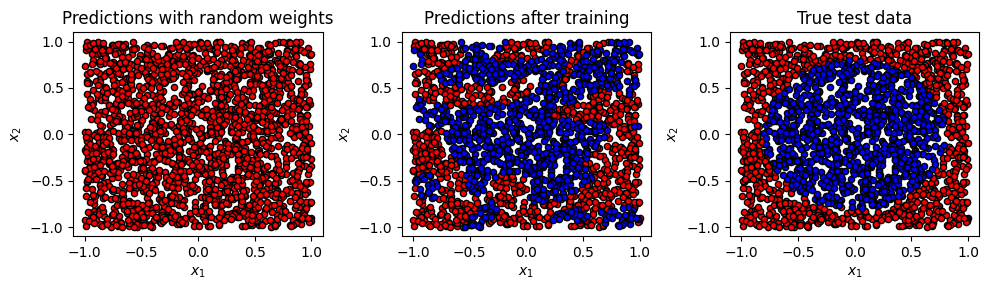

In [7]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: \n{}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# Cubic Space Classification

In [8]:
from sklearn.datasets import make_classification

n_samples = 500
n_features = 3
n_informative = 3
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=2.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]

In [9]:

# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2, n_features), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.395618 | Train accuracy: 0.437500 | Test Accuracy: 0.440000
Epoch:  1 | Loss: 0.340113 | Train accuracy: 0.510000 | Test accuracy: 0.400000
Epoch:  2 | Loss: 0.306696 | Train accuracy: 0.560000 | Test accuracy: 0.690000
Epoch:  3 | Loss: 0.322423 | Train accuracy: 0.527500 | Test accuracy: 0.560000
Epoch:  4 | Loss: 0.389099 | Train accuracy: 0.460000 | Test accuracy: 0.530000
Epoch:  5 | Loss: 0.326497 | Train accuracy: 0.545000 | Test accuracy: 0.500000
Epoch:  6 | Loss: 0.333291 | Train accuracy: 0.492500 | Test accuracy: 0.600000
Epoch:  7 | Loss: 0.332845 | Train accuracy: 0.522500 | Test accuracy: 0.490000
Epoch:  8 | Loss: 0.324177 | Train accuracy: 0.532500 | Test accuracy: 0.490000
Epoch:  9 | Loss: 0.336421 | Train accuracy: 0.502500 | Test accuracy: 0.560000
Epoch: 10 | Loss: 0.383934 | Train accuracy: 0.437500 | Test accuracy: 0.460000
